# Fourier filtering of Pauls Experimental data
*Connor Duffin*

In this notebook we look at the fourier filtering of the experimental data of Paul which is contained in the JFM paper. In this we look at the $\mathrm{Re} \approx 440$ flow. The approach that we take, in short:

1. For a single location consisting of time series measurements $(u_n)_{n = 1}^N$ we create a period reflection $(u_1, \ldots, u_N, u_{N - 1}, \ldots, u_1)$.
2. Take the (real-valued) FFT of this sequence to obtain coefficents $(\hat{u}_k)_{k = 1}^{2N - 1}$.
3. For some $q$ truncate the FFT to $(\hat{u}_k)_{k = 1}^{q}$, where $q < 2N$.
4. Compute $U_{\mathrm{recon}}$ from $(\hat{u}_k)_{k = 1}^{q}$, the Fourier-filtered reconstructed time series.
5. Using $U - U_{\mathrm{recon}}$ compute the relevant summary statistics.

To my knowledge, this will give an estimate of the "noise" of the process when compared to an $L^2$ smooth reconstruction in time. It is important to note that this assumption of smoothness is given in *time* and not in space. However one would imagine that so long as the spatial dynamics have similar degrees of smoothness this should result in similar sorts of measurement errors.

I.e. we are assuming some sort of measurement model along the lines of
$y^n = u_\mathrm{smooth}^n + \eta_n$, $\eta \sim \mathcal{N}(0, \sigma^2)$, point-wise.

In [1]:
import h5py
import os

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from tqdm import tqdm

fe.set_log_level(50)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
ds = xr.open_dataset("../data/Run08_G0_dt4.0_de1.0_ne5_velocity.nc")

u_spatial_averaged = np.mean(ds.U, axis=(1, 2, 3))
v_spatial_averaged = np.mean(ds.V, axis=(1, 2, 3))

idx_start = np.argmin(np.abs(u_spatial_averaged.values - 0.))
idx_end = len(u_spatial_averaged.values)

In [3]:
u_depth_averaged = np.mean(ds.U, axis=-1)
v_depth_averaged = np.mean(ds.V, axis=-1)

u_depth_averaged = u_depth_averaged.isel(time=slice(idx_start, idx_end))
v_depth_averaged = v_depth_averaged.isel(time=slice(idx_start, idx_end))

u_spatial_averaged = u_spatial_averaged.isel(time=slice(idx_start, idx_end))
v_spatial_averaged = v_spatial_averaged.isel(time=slice(idx_start, idx_end))

u_depth_averaged = u_depth_averaged.assign_coords(
    dict(time_rel=((u_depth_averaged["time"]  - u_depth_averaged["time"][0]) * 1e-9).astype(float)))
v_depth_averaged = v_depth_averaged.assign_coords(
    dict(time_rel=((v_depth_averaged["time"]  - v_depth_averaged["time"][0]) * 1e-9).astype(float)))

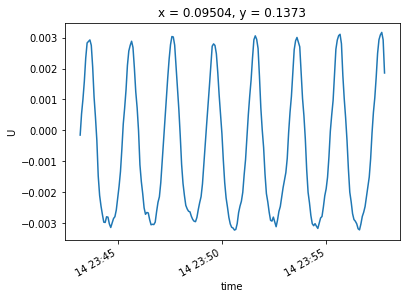

In [4]:
xi = 16
yi = 24

u_depth_averaged.isel(x=xi, y=yi).plot()
plt.show()

436


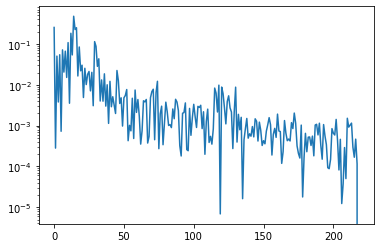

In [5]:
ud = u_depth_averaged.isel(x=xi, y=yi).to_numpy()
ud = np.concatenate((ud, ud[::-1]))

n = len(ud)
print(n)
ud_hat = np.fft.rfft(ud)

plt.semilogy(np.abs(ud_hat))
plt.show()

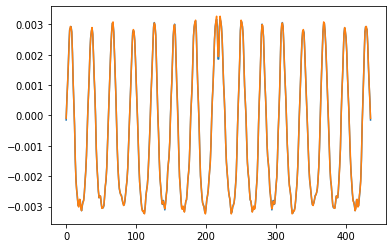

In [6]:
ud_filter = np.fft.irfft(ud_hat[:128], n=n)

plt.plot(ud)
plt.plot(ud_filter)
plt.show()

3.839220179709008e-05


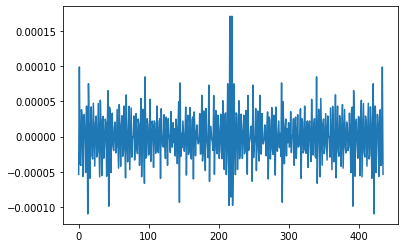

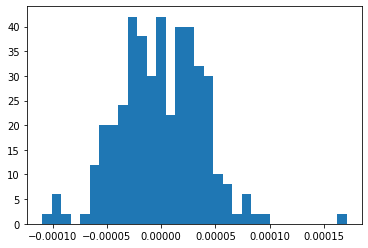

In [7]:
print(np.std(ud - ud_filter))
plt.plot(ud - ud_filter)
plt.show()

plt.hist(ud - ud_filter, bins=32)
plt.show()

(218, 64, 48)


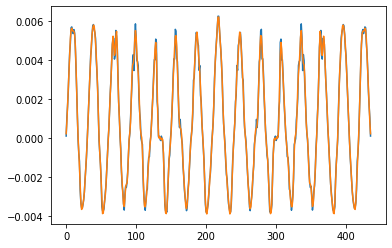

In [8]:
U = u_depth_averaged.to_numpy()
print(U.shape)

U_periodic = np.concatenate((U, np.flip(U, axis=0)), axis=0)

U_hat = np.fft.rfft(U_periodic, axis=0)
U_filtered = np.fft.irfft(U_hat[:100, :, :], axis=0, n=U_periodic.shape[0])
plt.plot(U_periodic[:, 10, 10])
plt.plot(U_filtered[:, 10, 10])
plt.show()

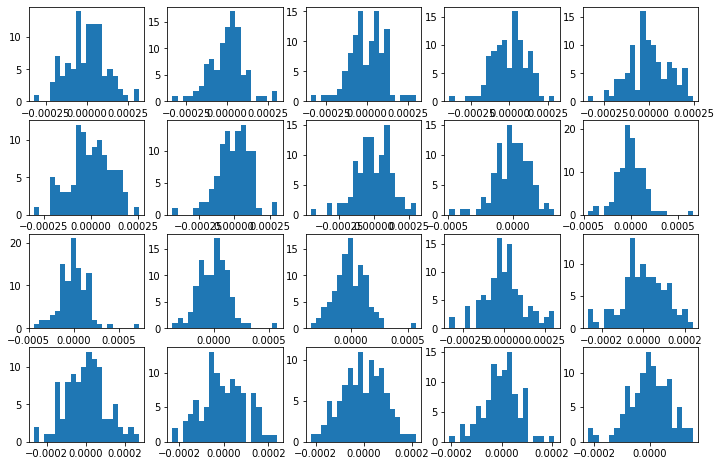

In [9]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))

axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.hist(U_filtered[:100, i, i] - U_periodic[:100, i, i], bins=20)
    
plt.show()

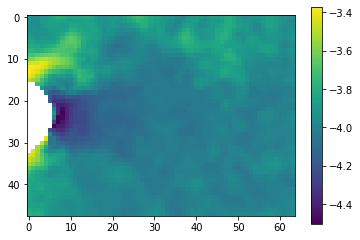

In [10]:
im = plt.imshow(
    np.log10(np.std(U_filtered[:200, :, :] 
                        - U_periodic[:200, :, :], axis=0).T))
plt.colorbar(im)
plt.show()